In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sys, os
sys.path.append("C:/Users/lheindrich/Documents/Scalable-discovery/metacontroller/")
os.chdir("C:/Users/lheindrich/Documents/Scalable-discovery/metacontroller/")

%load_ext autoreload
%autoreload 2
sns.set(style="darkgrid")

In [2]:
conditions = {
    0: "NoFeedback",
    1: "GoalSwitchingDemonstration",
    2: "NoGoalSwitchingDemonstration",
    3: "FeedbackSmallEnvironment"
}

In [3]:
df_after_exclusion = pd.read_csv(os.getcwd() + "/metacontroller_main/main_excluded.csv", converters={'AgreementDetails': eval})
df_after_exclusion["NamedCondition"] = df_after_exclusion["Condition"].apply(lambda x: conditions[x])

<AxesSubplot:xlabel='ExpectedScore', ylabel='Count'>

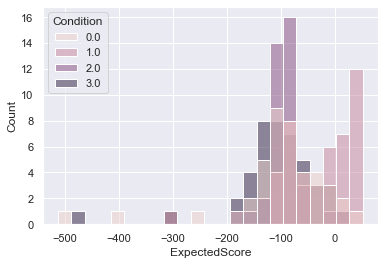

In [4]:
sns.histplot(data=df_after_exclusion.groupby("Participant").mean(), x="ExpectedScore", hue="Condition")

In [5]:
from scipy.stats import iqr
df_after_exclusion.groupby("NamedCondition")["ExpectedScore"].agg(["median", iqr])

,median,iqr
NamedCondition,,
FeedbackSmallEnvironment,-75.0,127.50
GoalSwitchingDemonstration,-20.0,140.00
NoFeedback,-100.0,98.75
NoGoalSwitchingDemonstration,-100.0,35.00


In [6]:
df_after_exclusion.groupby("Condition").agg(["mean", "std"])[["ExpectedScore", "ClickAgreement", "GoalAgreement", "SubgoalAgreement", "TermAgreement", "GoalTermAgreement", "SubgoalTermAgreement"]].round(4)

ExpectedScore           ClickAgreement         GoalAgreement  \
                   mean       std           mean     std          mean   
Condition                                                                
0             -103.3095  173.6896         0.2433  0.2349        0.5776   
1              -26.7111  121.8664         0.5994  0.2894        0.7821   
2              -94.4103   51.7482         0.4298  0.2258        0.7773   
3             -108.4884  179.6750         0.1722  0.1427        0.3601   

                  SubgoalAgreement         TermAgreement          \
              std             mean     std          mean     std   
Condition                                                          
0          0.3804           0.2447  0.3474        0.6919  0.1942   
1          0.3034           0.7271  0.3580        0.7635  0.2069   
2          0.2853           0.2150  0.3465        0.6835  0.1935   
3          0.3355           0.3012  0.2874        0.6305  0.1434   

          GoalTermAgreement         SubgoalTermAgreement          
                       mean     std                 mean     std  
Condition                                                         
0                    0.7175  0.3006               0.6185  0.2981  
1                    0.8400  0.2275               0.7966  0.2988  
2                    0.7819  0.2728               0.5491  0.3294  
3                    0.5731  0.3007               0.5821  0.2721

In [7]:
print("Total participants", len(df_after_exclusion["Participant"].unique()))
df_after_exclusion.groupby(["NamedCondition", "Participant"]).count()["TrialId"].reset_index().groupby("NamedCondition").count()

Total participants 169


,Participant,TrialId
NamedCondition,,
FeedbackSmallEnvironment,43,43
GoalSwitchingDemonstration,45,45
NoFeedback,42,42
NoGoalSwitchingDemonstration,39,39


In [8]:
accepted_participants = df_after_exclusion["Participant"].unique().tolist()

import json
path = os.getcwd() + "/metacontroller_main/dataclips_qjlyuocdzgjlonohmrotzgfvlhny.json"
data = json.load(open(path))

df_index = ["Participant", "Condition", "TrialId", "Score", "NumClicks", "TestEnv", 
"HighRiskClicks"]
df_data = []
high_risk_clicks = [8, 23, 38, 53]

known_workers = []
good_responses = 0

# Parse raw mturk data into dataframe
print("Parsing participant responses...")
for p_index, p_data in enumerate(data["values"]):
    # Filter out empty responses
    response_data = p_data[-1]
    if response_data != None:
        p_res_obj = json.loads(response_data)
        condition = p_res_obj["condition"]
        # Obfuscate worker ID for publishing
        worker = p_index # p_res_obj["workerId"]
        if worker in known_workers:
            print("Duplicate worker", worker)
        else: 
            known_workers.append(worker)
        p_res = p_res_obj["data"]
        # Filter our incomplete trials
        # Get last instruction index
        # Test trials start after the last instruction
        # Index of that in the experiment is variable due to repeated instructions/quiz
        instruction_index = 0
        if condition == 0 and worker in accepted_participants:
            for i in range(len(p_res)):
                #print(p_res[i]["trialdata"]["trial_type"])
                if p_res[i]["trialdata"]["trial_type"] == "instructions":
                    instruction_index = i+1
            #print(instruction_index)
            if len(p_res) > instruction_index and (instruction_index>14):
                good_responses += 1
                for i in range(instruction_index-6, instruction_index-1):
                    trial = p_res[i]
                    trialdata = trial["trialdata"]
                    if trialdata["trial_type"] != "mouselab-mdp":
                        print("Participant", worker)
                        print([p_res[i]["trialdata"]["trial_type"] for i in range(len(p_res))])
                    trial = p_res[i]
                    trialdata = trial["trialdata"]
                    trialid = trialdata["trial_id"]
                    queries = trialdata["queries"]["click"]["state"]["target"]
                    path = trialdata["path"]
                    score = trialdata["score"]
                    trial_id = int(trialdata["trial_id"])
                    num_risk_clicks = sum([1 for el in high_risk_clicks if str(el) in queries])
                    df_data.append([worker, condition, trialid, score, len(queries), trial_id, num_risk_clicks])

print("Parsed", good_responses, "complete participant responses")
train_df = pd.DataFrame(df_data, columns=df_index)

print(train_df.groupby("Participant").mean().groupby("Condition").mean()[["NumClicks", "HighRiskClicks"]])

demo_meta = [
    {"clicks":[15, 8],"stateRewards":[0, 0, 10, -10, -10, 5, 5, -5, 0, 5, -5, 5, 5, 5, 5, 100, 0, -5, 10, 10, -10, 5, 10, 0, 5, 5, -10, 10, -5, -10, 75, 0, -5, 5, 5, 5, 10, -5, 0, -5, 5, 5, -5, 10, -5, 25, 0, -10, -5, 10, 10, -5, -10, 0, -5, 5, -10, -5, 10, 5, 100]},
    {"clicks":[15, 8],"stateRewards":[0, 0, -5, 5, 10, 5, 5, -10, 0, -5, 5, 10, -5, -10, -5, 100, 0, -5, 10, -10, 5, 10, -10, 0, 10, -10, 5, 10, 5, -5, 0, 0, -5, -5, -5, 10, 10, -5, 0, -5, -5, -5, 5, -5, -5, 75, 0, 10, -10, 5, -5, -5, 5, 0, -5, -10, -10, 5, 5, 5, 100]},
    {"clicks":[15, 30, 45, 38],"stateRewards":[0, 0, 10, 5, -10, -10, -5, -5, 0, -5, 5, 5, 10, 5, 5, 25, 0, 10, -5, -10, -10, 10, -10, 0, -10, -10, -5, 10, -5, 10, 0, 0, -5, 10, 10, -5, -5, -5, 0, 5, -10, 5, 10, -10, -5, 100, 0, 5, -10, -5, -10, 5, -10, 0, 5, -10, 5, 10, 10, -5, 75]},
    {"clicks":[15, 8, 30, 23],"stateRewards":[0, 0, -5, -10, -10, -10, -5, -10, -1500, -5, -10, 10, 10, -10, 5, 75, 0, 5, 5, 5, -5, 5, 10, 0, 10, 10, 10, -10, 5, 10, 75, 0, 10, -10, -10, 10, 10, 10, 0, -5, 5, -5, -5, -5, 10, 0, 0, 5, 10, -10, 5, 5, -5, -1500, -10, -10, 10, -10, -10, -5, 25]},
    {"clicks":[15, 8],"stateRewards":[0, 0, 5, 5, -5, -10, -10, 10, 0, -10, 5, 10, -10, 5, 10, 75, 0, -5, 10, 5, 5, -10, -5, 0, -5, -5, 5, 5, 5, 5, 100, 0, 10, -5, -10, -5, -10, 10, -1500, 5, 5, 10, -10, 10, -5, 100, 0, 10, -5, -10, -5, -10, 10, 0, -5, 10, 10, -5, 10, -5, 75]}
]

print("Average clicks optimal policy", np.mean([len(x["clicks"]) for x in demo_meta]))
print("Average high risk clicks optimal policy", np.mean([len([click for click in x["clicks"] if click in high_risk_clicks]) for x in demo_meta]))

Parsing participant responses...
Parsed 42 complete participant responses
           NumClicks  HighRiskClicks
Condition                           
0.0         8.442857        0.604762
Average clicks optimal policy 2.8
Average high risk clicks optimal policy 1.2


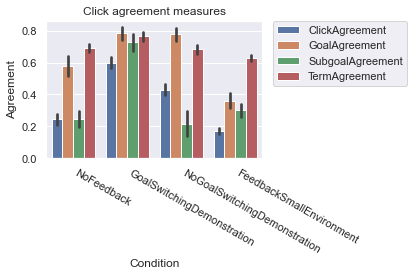

In [9]:
# Click Agreement
dfs = []
for category in ("ClickAgreement", "GoalAgreement", "SubgoalAgreement", "TermAgreement"):
    partial_df = df_after_exclusion[["Condition", category]].copy()
    partial_df.columns = ["Condition", "Agreement"]
    partial_df["Measurement"] = category
    dfs.append(partial_df)
agreement_df = pd.concat(dfs)
ax = sns.barplot(data=agreement_df[~agreement_df["Agreement"].isna()], x="Condition", y="Agreement", hue="Measurement")
_ = ax.set_xticklabels([conditions[x] for x in ax.get_xticks()], rotation=-30, ha='left')
_ = ax.set_title("Click agreement measures")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("./metacontroller_main/img/click_agreement.png")

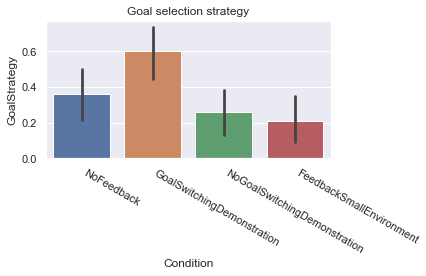

In [10]:
ax = sns.barplot(data=df_after_exclusion.groupby("Participant").median(), x="Condition", y="GoalStrategy")

_ = ax.set_xticklabels([conditions[x] for x in ax.get_xticks()], rotation=-30, ha='left')

plt.title("Goal selection strategy")
plt.tight_layout()
plt.savefig("./metacontroller_main/img/goal_strategy.png")

In [11]:
df_after_exclusion.groupby("Participant").median().groupby("Condition").agg(["mean"])["GoalStrategy"]

,mean
Condition,
0.0,0.357143
1.0,0.600000
2.0,0.256410
3.0,0.209302


In [12]:
counts = df_after_exclusion.groupby("Participant").median().groupby("Condition").sum()["GoalStrategy"].astype(int).tolist()
nobs = df_after_exclusion.groupby("Participant").median().groupby("Condition").count()["GoalStrategy"].tolist()
print(counts)
print(nobs)

[15, 27, 10, 9]
[42, 45, 39, 43]


In [13]:
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests
counts = df_after_exclusion.groupby("Participant").median().groupby("Condition").sum()["GoalStrategy"].astype(int).tolist()
nobs = df_after_exclusion.groupby("Participant").median().groupby("Condition").count()["GoalStrategy"].tolist()
comparisons = ((1, 0), (1, 2), (1, 3))
stats, pvals = [], []
for comp in comparisons:  
    count = np.array([counts[comp[0]], counts[comp[1]]])
    nob = np.array([nobs[comp[0]], nobs[comp[1]]])
    stat, pval = proportions_ztest(count, nob)
    stats.append(stat)
    pvals.append(pval)

p_adjusted = multipletests(pvals, method="fdr_bh")[1]
print(pvals)
print(p_adjusted)
for comp, stat, pval, p_new in zip(comparisons, stats, pvals, p_adjusted):
    print(f"Z-test between condition {conditions[comp[0]]} and {conditions[comp[1]]}: z={np.round(stat, 3)}, p={np.round(pval, 4)}, corrected={np.round(p_new, 4)}")

[0.02349914395169661, 0.001558813676770714, 0.0001943646209356298]
[0.02349914 0.00233822 0.00058309]
Z-test between condition GoalSwitchingDemonstration and NoFeedback: z=2.265, p=0.0235, corrected=0.0235
Z-test between condition GoalSwitchingDemonstration and NoGoalSwitchingDemonstration: z=3.164, p=0.0016, corrected=0.0023
Z-test between condition GoalSwitchingDemonstration and FeedbackSmallEnvironment: z=3.726, p=0.0002, corrected=0.0006


In [14]:
click_agreement_per_participant = df_after_exclusion.groupby("Participant").mean()[["Condition", "ClickAgreement"]]
click_agreement_per_participant["LearnedStrategy"] = click_agreement_per_participant["ClickAgreement"] > 0.5
click_agreement_per_participant.groupby("Condition").mean()["LearnedStrategy"]

Condition
0.0    0.095238
1.0    0.644444
2.0    0.333333
3.0    0.000000
Name: LearnedStrategy, dtype: float64

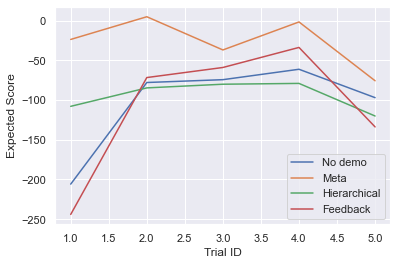

In [15]:
# Plot of scores per condition

score_per_trial = df_after_exclusion.groupby(["Condition", "TrialId"]).mean()[["Score", "ExpectedScore"]]
score_per_trial = score_per_trial.reset_index()


plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==0], label="No demo")
plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==1], label="Meta")
plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==2], label="Hierarchical")
plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==3], label="Feedback")
plt.xlabel("Trial ID")
plt.ylabel("Expected Score")
plt.legend()

Text(0.5, 1.0, 'Optimal tutor')

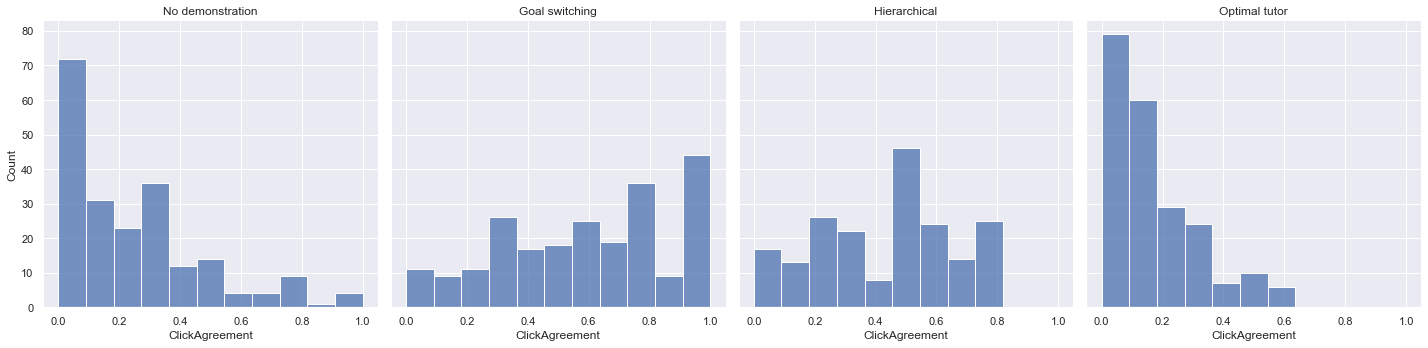

In [16]:
g = sns.displot(data=df_after_exclusion, x="ClickAgreement", col="Condition", facet_kws=dict(margin_titles=True))

axes = g.axes.flatten()
axes[0].set_title("No demonstration")
axes[1].set_title("Goal switching")
axes[2].set_title("Hierarchical")
axes[3].set_title("Optimal tutor")

<AxesSubplot:xlabel='Condition', ylabel='ExpectedScore'>

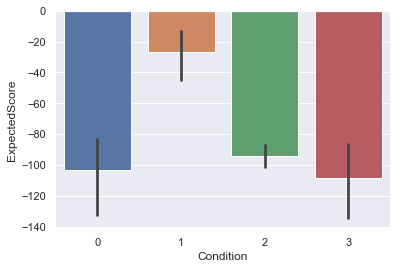

In [17]:
sns.barplot(x="Condition",y="ExpectedScore",data=df_after_exclusion)

In [18]:
df_after_exclusion.groupby("Condition").std()["ExpectedScore"]

Condition
0    173.689555
1    121.866368
2     51.748160
3    179.674989
Name: ExpectedScore, dtype: float64